# Configure Hydra to load the config file for models and datasets

In [51]:
from hydra import initialize, compose

In [52]:
with initialize(version_base=None, config_path="config"):
    cfg = compose(overrides=["+models=gcn", '+datasets=mutag'])
    print(cfg)

{'models': {'gnn_saving_path': 'checkpoints', 'gnn_name': 'gcn', 'param': {'ba_2motifs': {'learning_rate': 0.005, 'weight_decay': 0.0, 'milestones': 'None', 'gamma': 'None', 'batch_size': 32, 'num_epochs': 1000, 'num_early_stop': 100, 'gnn_latent_dim': [20, 20, 20], 'gnn_dropout': 0.0, 'add_self_loop': True, 'gcn_adj_normalization': False, 'gnn_emb_normalization': False, 'graph_classification': True, 'node_classification': False, 'gnn_nonlinear': 'relu', 'readout': 'mean', 'fc_latent_dim': [], 'fc_dropout': 0.0, 'fc_nonlinear': 'relu'}, 'bace': {'learning_rate': 0.01, 'weight_decay': 0.0, 'milestones': 'None', 'gamma': 'None', 'batch_size': 64, 'num_epochs': 400, 'num_early_stop': 0, 'gnn_latent_dim': [128, 128, 128], 'gnn_dropout': 0.0, 'add_self_loop': True, 'gcn_adj_normalization': True, 'gnn_emb_normalization': False, 'graph_classification': True, 'node_classification': False, 'gnn_nonlinear': 'relu', 'readout': 'max', 'fc_latent_dim': [], 'fc_dropout': 0.0, 'fc_nonlinear': 'relu'}

In [53]:
cfg.models.param = cfg.models.param[cfg.datasets.dataset_name]

In [54]:
import os
import time
from omegaconf import OmegaConf

import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets.datasets import get_dataset, get_data_loader
from explainers.instance_shapley_rule import KernelShapRuleInstance
from models.gnnNets import get_gnnNets
from utils import parse_rules
import numpy as np
from tqdm import tqdm

In [55]:
def simple_rule_score(model, dataset, dataloader, activation_rules, k=100, instance=None):
    estimator = KernelShapRuleInstance('ba2', model, dataset, dataloader, activation_rules, targeted_class=0,
                               strategy='deactivate', instance=instance)
    start = time.time()
    estimator.add_sampled_coalition(k)
    estimator.fit()
    values_c0 = estimator.get_shapley_values()
    end = time.time()


    estimator = KernelShapRuleInstance('ba2', model, dataset, dataloader, activation_rules, targeted_class=1,
                               strategy='deactivate', instance=instance)
    start = time.time()
    estimator.add_sampled_coalition(k)
    estimator.fit()
    values_c1 = estimator.get_shapley_values()
    end = time.time()

    return values_c0, values_c1



def progressive_rule_score(model, dataset, dataloader, activation_rules, targeted_class=0, instance=None):
    """
    Compute the progressive rule score for each rule in the activation_rules list
    :param model: GNN model
    :param dataset: dataset
    :param dataloader: dataloader
    :param activation_rules: list of rules
    :param targeted_class: target class
    :return: list of progressive rule scores
    """
    progressive_rule_scores = []
    estimator = KernelShapRuleInstance('ba2', model, dataset, dataloader, activation_rules, targeted_class=targeted_class, instance=instance)
    for _ in tqdm(range(2)):
        estimator.add_sampled_coalition(100)
        estimator.fit()
        progressive_rule_scores.append(estimator.get_shapley_values())
    return progressive_rule_scores



In [56]:
from tqdm import tqdm

def run(config):
    dataset = get_dataset(
        dataset_root=config.datasets.dataset_root,
        dataset_name=config.datasets.dataset_name,
    )
    dataset.data.x = dataset.data.x.float()
    dataset.data.y = dataset.data.y.squeeze().long()

    print(dataset)
    print(max([d.num_nodes for d in dataset]))
    # Get only train set
    model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models)
    # Load model state dict
    pretrained_model = torch.load(
        "../" + config.models.gnn_saving_path + "/" + f'{config.datasets.dataset_name}/{config.models.gnn_name}_3l_best.pth')
    model.load_state_dict(pretrained_model['net'])
    dataloader = get_data_loader(dataset, config.models.param.batch_size, config.datasets.random_split_flag,
                                 config.datasets.data_split_ratio, config.datasets.seed)

    activation_rules = parse_rules(f'../ExplanationEvaluation/{config.datasets.dataset_name}_encode_motifs.csv', emb_size=128)
    print(f'Activation rules length: {len(activation_rules)}')
    # Only keep acitvation rule of class 0
    activation_rules = [rule for rule in activation_rules if rule[2] == 0]
    c0_contribs = []
    c1_contribs = []

    for data in tqdm(dataset):
        instance_rule_score = simple_rule_score(model, dataset, dataloader, activation_rules, k=100, instance=data)
        c0_contribs.append(instance_rule_score[0])
        c1_contribs.append(instance_rule_score[1])

    c0_contribs = np.array(c0_contribs)
    c1_contribs = np.array(c1_contribs)
    return c0_contribs, c1_contribs



In [57]:
def plot_instance_rule_contrib(contrib_array):
    """
    Plot the contribution of each rule in the instance
    :param contrib_array: array of contributions of each rule
    :return: None
    """
    # Plot a beeswarm plot of the contributions
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.title("Rule contribution to the prediction")
    plt.ylabel("Rule")
    plt.xlabel("COntribution")

    # Plot contribution using density box horizontal with one row for each rule
    plt.boxplot(contrib_array, vert=False, showfliers=False)
    plt.show()

In [58]:
contribs = run(cfg)

/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


MUTAG(188)
28
Activation rules length: 46


  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [06:31<00:00,  2.08s/it]


In [59]:
np.save(f'{cfg.datasets.dataset_name}_contribs_c0.npy', contribs[0])
np.save(f'{cfg.datasets.dataset_name}_contribs_c1.npy', contribs[1])

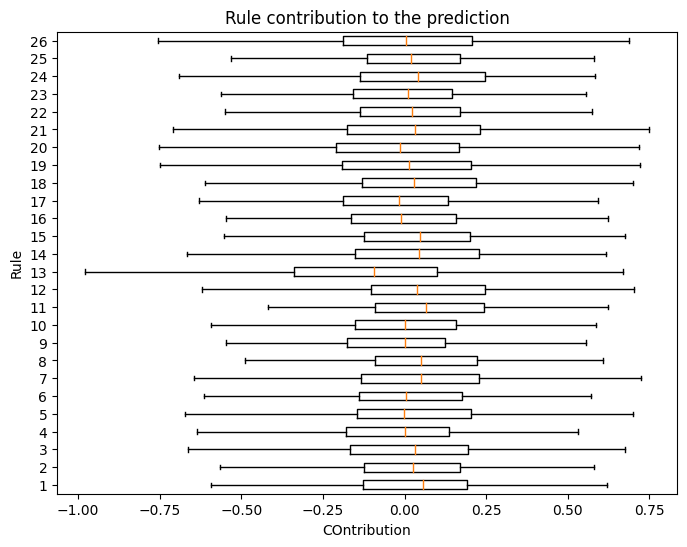

In [60]:
plot_instance_rule_contrib(contribs[1])

In [61]:
from utils import get_graph_list_from_rule

In [69]:
from tqdm import tqdm

def run(config):
    dataset = get_dataset(
        dataset_root=config.datasets.dataset_root,
        dataset_name=config.datasets.dataset_name,
    )
    dataset.data.x = dataset.data.x.float()
    dataset.data.y = dataset.data.y.squeeze().long()

    print(dataset)
    print(max([d.num_nodes for d in dataset]))
    # Get only train set
    model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models)
    # Load model state dict
    pretrained_model = torch.load(
        "../" + config.models.gnn_saving_path + "/" + f'{config.datasets.dataset_name}/{config.models.gnn_name}_3l_best.pth')
    model.load_state_dict(pretrained_model['net'])
    dataloader = get_data_loader(dataset, config.models.param.batch_size, config.datasets.random_split_flag,
                                 config.datasets.data_split_ratio, config.datasets.seed)

    activation_rules = parse_rules(f'../ExplanationEvaluation/{config.datasets.dataset_name}_encode_motifs.csv', emb_size=128)
    print(f'Activation rules length: {len(activation_rules)}')
    # Only keep acitvation rule of class 0
    activation_rules_c0 = [rule for rule in activation_rules if rule[2] == 0]
    rule_ids = np.arange(len(activation_rules))
    rule_id_list_c0 = [rule_ids[i] for i in range(len(activation_rules)) if activation_rules[i][2] == 0]
    rule_id_list_c1 = [rule_ids[i] for i in range(len(activation_rules)) if activation_rules[i][2] == 1]
    rules_contrib_c0 = [[] for _ in range(len(activation_rules_c0))]
    rules_contrib_c1 = [[] for _ in range(len(activation_rules_c0))]

    rules_graphs_list =[]
    for rule_id, _ in enumerate(activation_rules_c0):
        path = f'../{config.datasets.dataset_name}/{config.datasets.dataset_name}_gcn_gstarx_rule_{rule_id_list_c0[rule_id]}.txt'
        rules_graphs_list.append(get_graph_list_from_rule(dataset, path))
    for graph_id, data in tqdm(enumerate(dataset)):
        instance_rule_score = simple_rule_score(model, dataset, dataloader, activation_rules_c0, k=100, instance=data)
        for rule_id in range(len(rule_id_list_c0)):
            graph_list = rules_graphs_list[rule_id]
            if graph_id in graph_list:
                rules_contrib_c0[rule_id].append(instance_rule_score[0][rule_id])
                rules_contrib_c1[rule_id].append(instance_rule_score[1][rule_id])

    # Remove rules with no contribution
    rules_contrib_c0 = [rule for rule in rules_contrib_c0 if rule != []]
    rules_contrib_c1 = [rule for rule in rules_contrib_c1 if rule != []]

    plt.figure(figsize=(8, 6))
    plt.title("Rule contribution to the prediction")
    plt.ylabel("Rule")
    plt.xlabel("Contribution")

    # Plot contribution using density box horizontal with one row for each rule
    plt.boxplot(rules_contrib_c0, vert=False, showfliers=False)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.title("Rule contribution to the prediction")
    plt.ylabel("Rule")
    plt.xlabel("Contribution")

    # Plot contribution using density box horizontal with one row for each rule
    plt.boxplot(rules_contrib_c1, vert=False, showfliers=False)
    plt.show()

    return rules_contrib_c0, rules_contrib_c1



MUTAG(188)


/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


28
Activation rules length: 46


100%|██████████| 100/100 [00:00<00:00, 122.43it/s]
188it [06:40,  2.13s/it]


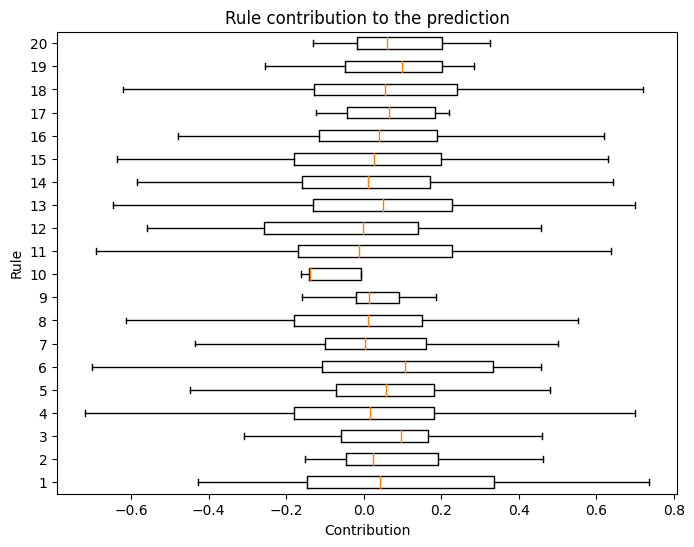

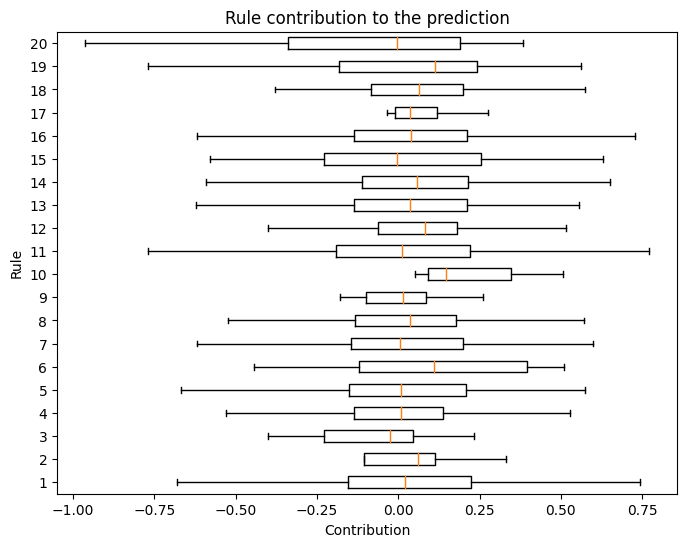

In [70]:
rules_contrib_c0, rules_contrib_c1 = run(cfg)

In [64]:
from tqdm import tqdm

def run(config):
    dataset = get_dataset(
        dataset_root=config.datasets.dataset_root,
        dataset_name=config.datasets.dataset_name,
    )
    dataset.data.x = dataset.data.x.float()
    dataset.data.y = dataset.data.y.squeeze().long()

    print(dataset)
    print(max([d.num_nodes for d in dataset]))
    # Get only train set
    model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models)
    # Load model state dict
    pretrained_model = torch.load(
        "../" + config.models.gnn_saving_path + "/" + f'{config.datasets.dataset_name}/{config.models.gnn_name}_3l_best.pth')
    model.load_state_dict(pretrained_model['net'])
    dataloader = get_data_loader(dataset, config.models.param.batch_size, config.datasets.random_split_flag,
                                 config.datasets.data_split_ratio, config.datasets.seed)

    activation_rules = parse_rules(f'../ExplanationEvaluation/{config.datasets.dataset_name}_encode_motifs.csv', emb_size=128)
    print(f'Activation rules length: {len(activation_rules)}')
    # Only keep acitvation rule of class 0
    activation_rules_c0 = [rule for rule in activation_rules if rule[2] == 1]
    rule_ids = np.arange(len(activation_rules))
    rule_id_list_c0 = [rule_ids[i] for i in range(len(activation_rules)) if activation_rules[i][2] == 1]
    rules_contrib_c0 = [[] for _ in range(len(activation_rules_c0))]
    rules_contrib_c1 = [[] for _ in range(len(activation_rules_c0))]

    rules_graphs_list =[]
    for rule_id, _ in enumerate(activation_rules_c0):
        path = f'../{config.datasets.dataset_name}/{config.datasets.dataset_name}_gcn_gstarx_rule_{rule_id_list_c0[rule_id]}.txt'
        rules_graphs_list.append(get_graph_list_from_rule(dataset, path))
    for graph_id, data in tqdm(enumerate(dataset)):
        instance_rule_score = simple_rule_score(model, dataset, dataloader, activation_rules_c0, k=100, instance=data)
        for rule_id in range(len(rule_id_list_c0)):
            graph_list = rules_graphs_list[rule_id]
            if graph_id in graph_list:
                rules_contrib_c0[rule_id].append(instance_rule_score[0][rule_id])
                rules_contrib_c1[rule_id].append(instance_rule_score[1][rule_id])

    # Remove rules with no contribution

    plt.figure(figsize=(8, 6))
    plt.title("Rule contribution to the prediction")
    plt.ylabel("Rule")
    plt.xlabel("Contribution")

    # Plot contribution using density box horizontal with one row for each rule
    plt.boxplot(rules_contrib_c0, vert=False, showfliers=False)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.title("Rule contribution to the prediction")
    plt.ylabel("Rule")
    plt.xlabel("Contribution")

    # Plot contribution using density box horizontal with one row for each rule
    plt.boxplot(rules_contrib_c1, vert=False, showfliers=False)
    plt.show()

    return rules_contrib_c0, rules_contrib_c1



/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


MUTAG(188)
28
Activation rules length: 46


0it [00:00, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 232.92it/s]
188it [42:09, 13.46s/it]


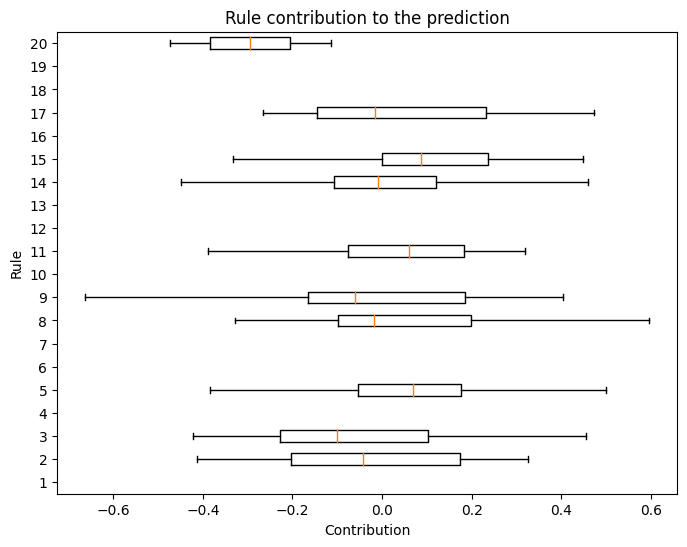

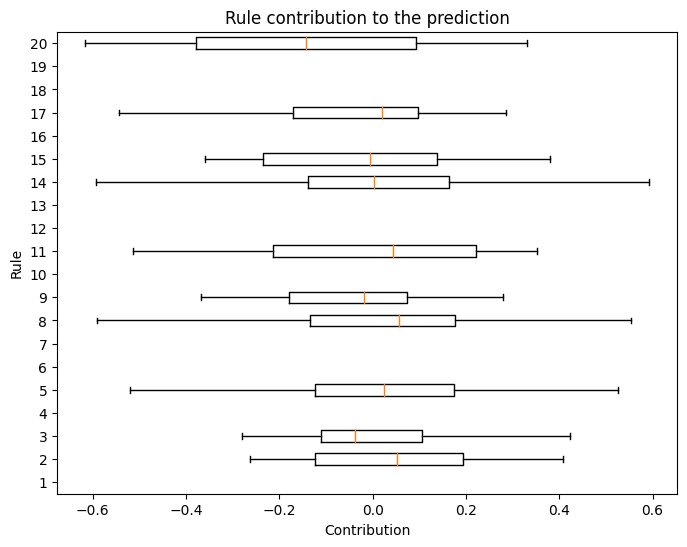

([[],
  [0.23137851766242404,
   0.20708936548125345,
   -0.17195529488608124,
   -0.32289835875843176,
   0.31714033339102143,
   -0.35230853781217475,
   -0.11441790127706769,
   -0.0011570176662072762,
   -0.27227657492553015,
   0.25032022003576704,
   -0.4138437176434482,
   -0.018035927509344123,
   0.13858087295667015,
   0.16829109887402777,
   -0.16930244681722062,
   -0.3328355554604183,
   -0.2124566074908818,
   -0.06693009506637707,
   0.14233429222154698,
   -0.15823235882161157,
   0.17562827328347586,
   0.32525196968957604],
  [0.027288291618488614,
   -0.07871402800792394,
   -0.25765830884549257,
   0.05251185668894978,
   -0.15777438384779718,
   0.3613911848563011,
   -0.42294847145640724,
   0.0009774971426200554,
   0.24933454253566645,
   -0.2178534087885482,
   -0.12232988755959046,
   -0.13861142945723354,
   -0.9609842060862878,
   0.32892107019678585,
   -0.27889990087886907,
   0.4565741342599688],
  [],
  [0.22389339291063148,
   -0.04746547317587274,
   0

In [65]:
run(cfg)

In [66]:
from tqdm import tqdm

def run(config, target):
    dataset = get_dataset(
        dataset_root=config.datasets.dataset_root,
        dataset_name=config.datasets.dataset_name,
    )
    dataset.data.x = dataset.data.x.float()
    dataset.data.y = dataset.data.y.squeeze().long()

    print(dataset)
    print(max([d.num_nodes for d in dataset]))
    # Get only train set
    model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models)
    # Load model state dict
    pretrained_model = torch.load(
        "../" + config.models.gnn_saving_path + "/" + f'{config.datasets.dataset_name}/{config.models.gnn_name}_3l_best.pth')
    model.load_state_dict(pretrained_model['net'])
    dataloader = get_data_loader(dataset, config.models.param.batch_size, config.datasets.random_split_flag,
                                 config.datasets.data_split_ratio, config.datasets.seed)

    activation_rules = parse_rules(f'../ExplanationEvaluation/{config.datasets.dataset_name}_encode_motifs.csv', emb_size=128)
    print(f'Activation rules length: {len(activation_rules)}')
    # Only keep acitvation rule of class 0
    activation_rules = [rule for rule in activation_rules if rule[2] == target]
    c0_contribs = []
    c1_contribs = []

    for data in tqdm(dataset):
        if data.y == target:
            instance_rule_score = simple_rule_score(model, dataset, dataloader, activation_rules, k=100, instance=data)
            c0_contribs.append(instance_rule_score[0])
            c1_contribs.append(instance_rule_score[1])

    plt.figure(figsize=(8, 6))
    plt.title(f"Rule contribution to the prediction, rule that target class {target}")
    plt.ylabel("Contribution")
    plt.xlabel("Rule")

    # Plot contribution using density box horizontal with one row for each rule (col)
    plt.boxplot(rules_contrib_c0, vert=False, showfliers=False)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.title(f"Rule contribution to the prediction, rule that target class {target}")
    plt.ylabel("Contribution")
    plt.xlabel("Rule")

    # Plot contribution using density box horizontal with one row for each rule
    plt.boxplot(rules_contrib_c1, vert=False, showfliers=False)
    plt.show()

    return rules_contrib_c0, rules_contrib_c1



/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


MUTAG(188)
28
Activation rules length: 46


  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [22:12<00:00,  7.09s/it]


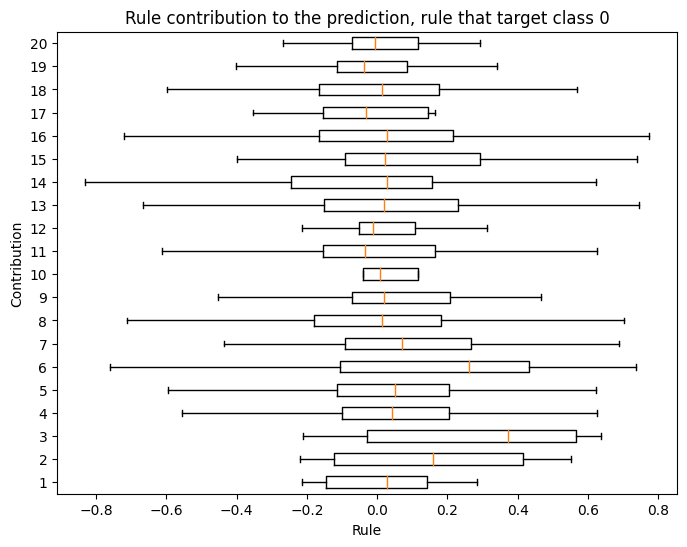

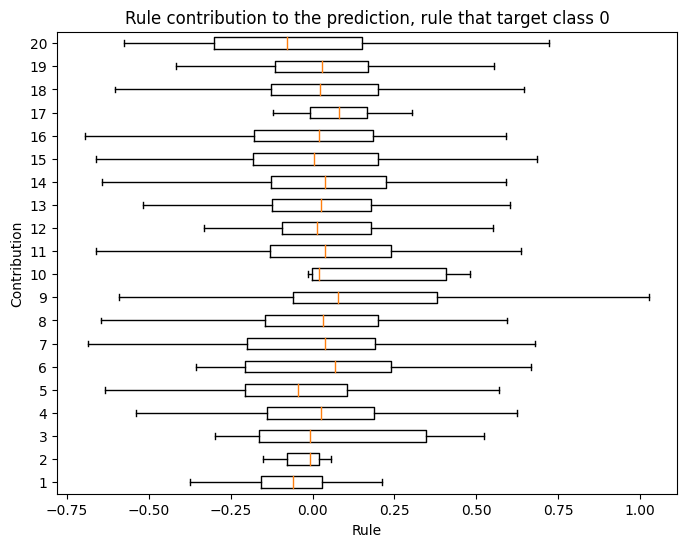

([[0.2514900221760078,
   0.16367340697461522,
   0.030301663792831827,
   0.07735197941797647,
   -0.16493777774354818,
   0.15858785438930495,
   -0.12733869589876357,
   -0.7638331348445822,
   -0.07631011354040461,
   0.029268529600960283,
   0.10697616589474718,
   0.12689914178582773,
   -0.03263858670895045,
   -0.19026897597599357,
   0.029763433190116956,
   -0.21399999143874676,
   0.24640303873630676,
   -0.06764091152792355,
   -0.024058330489531515,
   0.17453009411870646,
   0.2841966360364482,
   -0.17226574961857266,
   -0.750115198898955],
  [-0.16758203378389702,
   0.5085109753652808,
   -0.21949512801599674,
   0.03749623944960735,
   -0.10918185051433726,
   0.2823226493767427,
   0.5509334337826157,
   0.38320682677424006],
  [0.5508916622977247,
   0.6362206737288135,
   0.4641849896098806,
   0.0026800464915047607,
   -0.12814952631254062,
   -0.21078612701434574,
   0.2825800910924984,
   0.6038629997374472],
  [0.5191725278144458,
   0.16707011889019635,
   0.

In [67]:
run(cfg, 0)

/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


MUTAG(188)
28
Activation rules length: 46


100%|██████████| 188/188 [04:04<00:00,  1.30s/it]


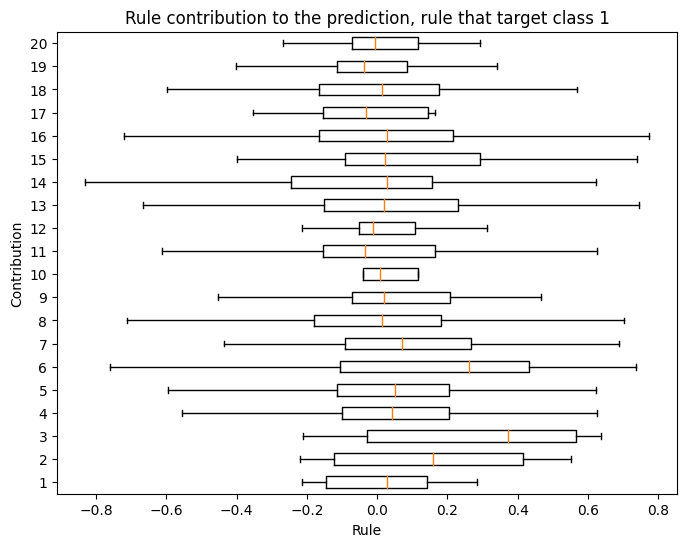

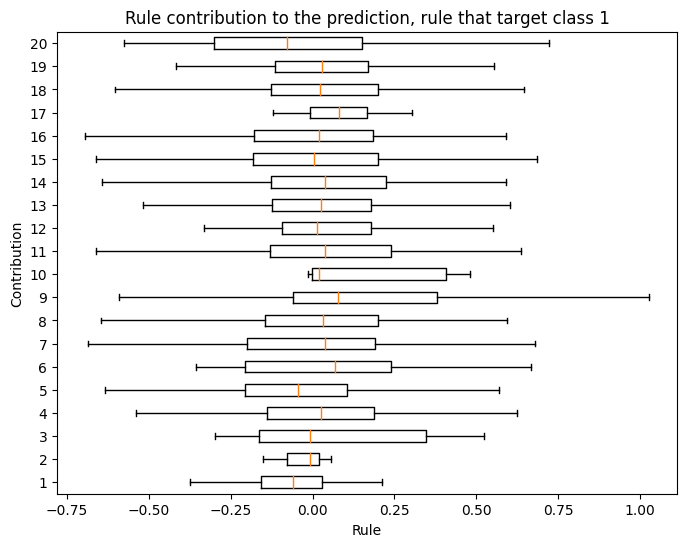

([[0.2514900221760078,
   0.16367340697461522,
   0.030301663792831827,
   0.07735197941797647,
   -0.16493777774354818,
   0.15858785438930495,
   -0.12733869589876357,
   -0.7638331348445822,
   -0.07631011354040461,
   0.029268529600960283,
   0.10697616589474718,
   0.12689914178582773,
   -0.03263858670895045,
   -0.19026897597599357,
   0.029763433190116956,
   -0.21399999143874676,
   0.24640303873630676,
   -0.06764091152792355,
   -0.024058330489531515,
   0.17453009411870646,
   0.2841966360364482,
   -0.17226574961857266,
   -0.750115198898955],
  [-0.16758203378389702,
   0.5085109753652808,
   -0.21949512801599674,
   0.03749623944960735,
   -0.10918185051433726,
   0.2823226493767427,
   0.5509334337826157,
   0.38320682677424006],
  [0.5508916622977247,
   0.6362206737288135,
   0.4641849896098806,
   0.0026800464915047607,
   -0.12814952631254062,
   -0.21078612701434574,
   0.2825800910924984,
   0.6038629997374472],
  [0.5191725278144458,
   0.16707011889019635,
   0.

In [68]:
run(cfg, 1)